In [1]:
import os, zipfile, random, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from collections import Counter

In [5]:
# SMART EXTRACTION + FOLDER DETECTION FIX

import zipfile, shutil, os
from pathlib import Path

# Define paths
DATA_ROOT = Path("./data_extracted_fixed")
TRAIN_ZIP = r"C:\Users\balaj\OneDrive\Documents\Guvi_Projects\Brain_Tumor_Classification\Dataset\train-20251107T155601Z-1-001.zip"
VALID_ZIP = r"C:\Users\balaj\OneDrive\Documents\Guvi_Projects\Brain_Tumor_Classification\Dataset\valid-20251107T160008Z-1-001.zip"
TEST_ZIP  = r"C:\Users\balaj\OneDrive\Documents\Guvi_Projects\Brain_Tumor_Classification\Dataset\test-20251107T155535Z-1-001.zip"

# Clean old extraction if exists
if DATA_ROOT.exists():
    shutil.rmtree(DATA_ROOT)
DATA_ROOT.mkdir(parents=True, exist_ok=True)

def smart_extract(zip_path, target_dir):
    """Extract zip and automatically detect the actual 'train/valid/test' folder level."""
    print(f"Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    print(f"Extracted to {target_dir}")
    
    # Find the real dataset folder (contains class subfolders)
    # e.g., /data/train/train/...  or /data/train/...
    candidates = list(Path(target_dir).rglob("train"))
    if not candidates:
        candidates = list(Path(target_dir).rglob("Train"))
    if candidates:
        print(f"Found train folder candidate: {candidates[0]}")
    return target_dir

# Extract all datasets
smart_extract(TRAIN_ZIP, DATA_ROOT / "train")
smart_extract(VALID_ZIP, DATA_ROOT / "valid")
smart_extract(TEST_ZIP,  DATA_ROOT / "test")

# Detect the deepest actual directories that contain class folders
def find_actual_dataset_dir(base_dir):
    base_dir = Path(base_dir)
    subdirs = [p for p in base_dir.rglob("*") if p.is_dir() and any(f.suffix.lower() in ['.jpg', '.jpeg', '.png'] for f in p.glob("*"))]
    if subdirs:
        # Return parent folder containing class folders
        parents = {p.parent for p in subdirs}
        best = min(parents, key=lambda p: len(p.parts))
        print(f"✅ Found valid dataset directory: {best}")
        return best
    else:
        print(f"⚠️ No images found under {base_dir}, check your zip structure.")
        return base_dir

TRAIN_DIR = find_actual_dataset_dir(DATA_ROOT / "train")
VALID_DIR = find_actual_dataset_dir(DATA_ROOT / "valid")
TEST_DIR  = find_actual_dataset_dir(DATA_ROOT / "test")

print(f"\nFinal dataset directories:")
print(f"Train dir: {TRAIN_DIR}")
print(f"Valid dir: {VALID_DIR}")
print(f"Test dir:  {TEST_DIR}")

# Quick verification
for root, dirs, files in os.walk(TRAIN_DIR):
    print(f"\nSample structure check:\n{root} -> {len(dirs)} class folders")
    print("Classes:", dirs)
    break

Extracting C:\Users\balaj\OneDrive\Documents\Guvi_Projects\Brain_Tumor_Classification\Dataset\train-20251107T155601Z-1-001.zip ...
Extracted to data_extracted_fixed\train
Found train folder candidate: data_extracted_fixed\train\train
Extracting C:\Users\balaj\OneDrive\Documents\Guvi_Projects\Brain_Tumor_Classification\Dataset\valid-20251107T160008Z-1-001.zip ...
Extracted to data_extracted_fixed\valid
Extracting C:\Users\balaj\OneDrive\Documents\Guvi_Projects\Brain_Tumor_Classification\Dataset\test-20251107T155535Z-1-001.zip ...
Extracted to data_extracted_fixed\test
✅ Found valid dataset directory: data_extracted_fixed\train\train
✅ Found valid dataset directory: data_extracted_fixed\valid\valid
✅ Found valid dataset directory: data_extracted_fixed\test\test

Final dataset directories:
Train dir: data_extracted_fixed\train\train
Valid dir: data_extracted_fixed\valid\valid
Test dir:  data_extracted_fixed\test\test

Sample structure check:
data_extracted_fixed\train\train -> 4 class fol

In [6]:
# 1) CONFIG

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = Path("data_extracted_fixed")   # already extracted (from your previous step)
TRAIN_DIR = DATA_ROOT / "train" / "train"
VALID_DIR = DATA_ROOT / "valid" / "valid"
TEST_DIR  = DATA_ROOT / "test" / "test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 128
EPOCHS = 15
OUTPUT_DIR = Path("models_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

In [7]:
# 2️) DATA PREPROCESSING (Fixed for RGB inputs)

print("✅ Preparing datasets...")

def create_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=img_size,
        shuffle=shuffle,
        seed=SEED,
        color_mode="rgb"   # 👈 Force 3-channel RGB to avoid grayscale mismatch
    )
    return ds

train_ds = create_dataset(TRAIN_DIR)
val_ds   = create_dataset(VALID_DIR, shuffle=False)
test_ds  = create_dataset(TEST_DIR, shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

# ✅ Sanity check: verify image shape
for images, labels in train_ds.take(1):
    print(f"Sample image batch shape: {images.shape}")
    print(f"Sample label batch shape: {labels.shape}")

# Normalize pixel values to [0–1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

✅ Preparing datasets...
Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Found 246 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Sample image batch shape: (128, 224, 224, 3)
Sample label batch shape: (128,)


In [8]:
# 3️) DATA AUGMENTATION

print("✅ Setting up augmentation...")
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

✅ Setting up augmentation...


In [9]:
# 4️) MODEL BUILDING (Fixed & Verified)

print("✅ Building models...")

# ---- Custom CNN ----
def build_custom_cnn(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

custom_cnn = build_custom_cnn((224,224,3), num_classes)
custom_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
custom_cnn.summary()

# ---- Transfer Learning Models ----
def build_transfer_model(base_model, num_classes=4):
    base_model.trainable = False
    inputs = layers.Input(shape=(224,224,3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

transfer_models = {
    "ResNet50": build_transfer_model(applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "MobileNetV2": build_transfer_model(applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "InceptionV3": build_transfer_model(applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
}

✅ Building models...


c:\Users\balaj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


✅ Training models...

Training CustomCNN ...
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3259 - loss: 1.8504

14/14 ━━━━━━━━━━━━━━━━━━━━ 106s 7s/step - accuracy: 0.4159 - loss: 1.5737 - val_accuracy: 0.2351 - val_loss: 1.3830
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 100s 7s/step - accuracy: 0.5729 - loss: 1.2070 - val_accuracy: 0.2351 - val_loss: 1.3847
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.5835 - loss: 1.1347 - val_accuracy: 0.2351 - val_loss: 1.3902
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.6236 - loss: 1.0426 - val_accuracy: 0.2351 - val_loss: 1.4030
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 92s 6s/step - accuracy: 0.6065 - loss: 1.0808 - val_accuracy: 0.2351 - val_loss: 1.4168


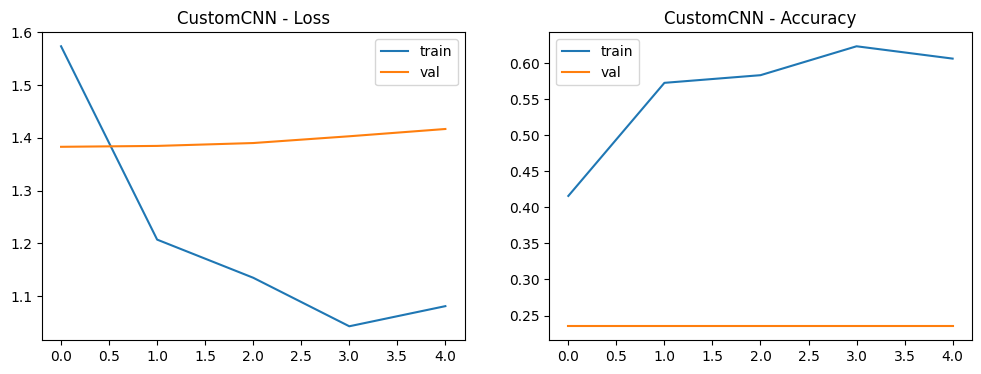


Training ResNet50 ...
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2136 - loss: 1.7647

14/14 ━━━━━━━━━━━━━━━━━━━━ 144s 10s/step - accuracy: 0.2201 - loss: 1.7276 - val_accuracy: 0.2470 - val_loss: 1.4857
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2257 - loss: 1.5919

14/14 ━━━━━━━━━━━━━━━━━━━━ 113s 8s/step - accuracy: 0.2330 - loss: 1.5818 - val_accuracy: 0.2450 - val_loss: 1.4028
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2431 - loss: 1.5409

14/14 ━━━━━━━━━━━━━━━━━━━━ 142s 10s/step - accuracy: 0.2366 - loss: 1.5322 - val_accuracy: 0.1653 - val_loss: 1.3751
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2448 - loss: 1.5059

14/14 ━━━━━━━━━━━━━━━━━━━━ 116s 8s/step - accuracy: 0.2602 - loss: 1.4846 - val_accuracy: 0.3227 - val_loss: 1.3700
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2647 - loss: 1.4870

14/14 ━━━━━━━━━━━━━━━━━━━━ 115s 9s/step - accuracy: 0.2702 - loss: 1.4771 - val_accuracy: 0.3227 - val_loss: 1.3682
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2765 - loss: 1.4754

14/14 ━━━━━━━━━━━━━━━━━━━━ 116s 8s/step - accuracy: 0.2956 - loss: 1.4631 - val_accuracy: 0.3247 - val_loss: 1.3653
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.2758 - loss: 1.4837 

14/14 ━━━━━━━━━━━━━━━━━━━━ 186s 14s/step - accuracy: 0.2749 - loss: 1.4886 - val_accuracy: 0.3367 - val_loss: 1.3616
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2962 - loss: 1.4552

14/14 ━━━━━━━━━━━━━━━━━━━━ 151s 11s/step - accuracy: 0.2891 - loss: 1.4571 - val_accuracy: 0.3367 - val_loss: 1.3584
Epoch 9/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2783 - loss: 1.4917

14/14 ━━━━━━━━━━━━━━━━━━━━ 128s 9s/step - accuracy: 0.2796 - loss: 1.4757 - val_accuracy: 0.3367 - val_loss: 1.3532
Epoch 10/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2907 - loss: 1.4493

14/14 ━━━━━━━━━━━━━━━━━━━━ 129s 9s/step - accuracy: 0.2903 - loss: 1.4456 - val_accuracy: 0.3466 - val_loss: 1.3486
Epoch 11/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2877 - loss: 1.4452

14/14 ━━━━━━━━━━━━━━━━━━━━ 110s 8s/step - accuracy: 0.2820 - loss: 1.4532 - val_accuracy: 0.3526 - val_loss: 1.3446
Epoch 12/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2677 - loss: 1.4708

14/14 ━━━━━━━━━━━━━━━━━━━━ 109s 8s/step - accuracy: 0.2838 - loss: 1.4520 - val_accuracy: 0.3665 - val_loss: 1.3408
Epoch 13/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2973 - loss: 1.4422

14/14 ━━━━━━━━━━━━━━━━━━━━ 109s 8s/step - accuracy: 0.2808 - loss: 1.4578 - val_accuracy: 0.3665 - val_loss: 1.3365
Epoch 14/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3099 - loss: 1.4270

14/14 ━━━━━━━━━━━━━━━━━━━━ 115s 8s/step - accuracy: 0.3109 - loss: 1.4272 - val_accuracy: 0.3845 - val_loss: 1.3328
Epoch 15/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2912 - loss: 1.4366

14/14 ━━━━━━━━━━━━━━━━━━━━ 108s 8s/step - accuracy: 0.2920 - loss: 1.4334 - val_accuracy: 0.3865 - val_loss: 1.3288


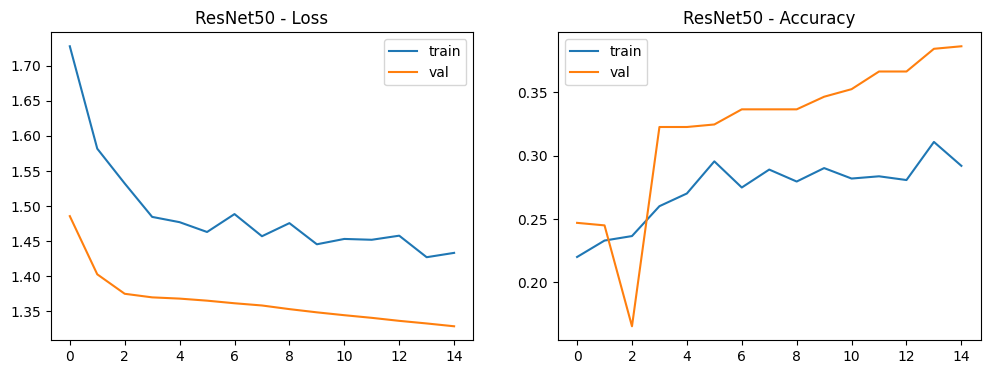


Training MobileNetV2 ...
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2073 - loss: 1.7969

14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.2142 - loss: 1.7559 - val_accuracy: 0.2371 - val_loss: 1.5765
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2455 - loss: 1.6633

14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.2555 - loss: 1.6447 - val_accuracy: 0.3167 - val_loss: 1.4813
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3257 - loss: 1.4834

14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.3322 - loss: 1.4624 - val_accuracy: 0.3606 - val_loss: 1.4095
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3496 - loss: 1.4648

14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.3729 - loss: 1.4310 - val_accuracy: 0.4124 - val_loss: 1.3462
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4084 - loss: 1.3670

14/14 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.4224 - loss: 1.3353 - val_accuracy: 0.4582 - val_loss: 1.2920
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4468 - loss: 1.2632

14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.4484 - loss: 1.2636 - val_accuracy: 0.4980 - val_loss: 1.2431
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4775 - loss: 1.2230

14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.4850 - loss: 1.2146 - val_accuracy: 0.5239 - val_loss: 1.2001
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4940 - loss: 1.2205

14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5192 - loss: 1.1816 - val_accuracy: 0.5478 - val_loss: 1.1619
Epoch 9/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4999 - loss: 1.1529

14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5139 - loss: 1.1490 - val_accuracy: 0.5757 - val_loss: 1.1281
Epoch 10/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5548 - loss: 1.0975

14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5817 - loss: 1.0725 - val_accuracy: 0.5916 - val_loss: 1.0943
Epoch 11/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5540 - loss: 1.0613

14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5646 - loss: 1.0551 - val_accuracy: 0.6056 - val_loss: 1.0664
Epoch 12/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5759 - loss: 1.0291

14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5882 - loss: 1.0064 - val_accuracy: 0.6175 - val_loss: 1.0432
Epoch 13/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5888 - loss: 0.9860

14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5941 - loss: 0.9907 - val_accuracy: 0.6175 - val_loss: 1.0221
Epoch 14/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5973 - loss: 0.9916

14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.6100 - loss: 0.9755 - val_accuracy: 0.6255 - val_loss: 1.0002
Epoch 15/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6218 - loss: 0.9486

14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.6395 - loss: 0.9218 - val_accuracy: 0.6355 - val_loss: 0.9840


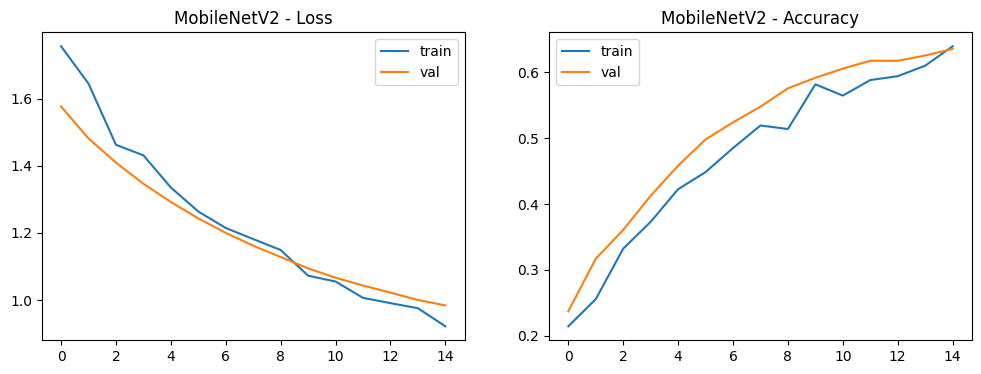


Training InceptionV3 ...
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3041 - loss: 1.6019

14/14 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.3091 - loss: 1.5774 - val_accuracy: 0.3825 - val_loss: 1.3399
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3400 - loss: 1.4639

14/14 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.3646 - loss: 1.4339 - val_accuracy: 0.4562 - val_loss: 1.2389
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3865 - loss: 1.4305

14/14 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - accuracy: 0.4024 - loss: 1.3987 - val_accuracy: 0.4980 - val_loss: 1.1661
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4198 - loss: 1.3354

14/14 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.4389 - loss: 1.2953 - val_accuracy: 0.5319 - val_loss: 1.1057
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4961 - loss: 1.2036

14/14 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.5044 - loss: 1.1928 - val_accuracy: 0.5558 - val_loss: 1.0538
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4806 - loss: 1.2138

14/14 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.5080 - loss: 1.1674 - val_accuracy: 0.5777 - val_loss: 1.0067
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5187 - loss: 1.1138

14/14 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.5422 - loss: 1.0954 - val_accuracy: 0.5956 - val_loss: 0.9757
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5635 - loss: 1.0647

14/14 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.5640 - loss: 1.0562 - val_accuracy: 0.6016 - val_loss: 0.9474
Epoch 9/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5729 - loss: 1.0216

14/14 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.5740 - loss: 1.0244 - val_accuracy: 0.6116 - val_loss: 0.9310
Epoch 10/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5983 - loss: 1.0130

14/14 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.6112 - loss: 0.9940 - val_accuracy: 0.6315 - val_loss: 0.8989
Epoch 11/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6003 - loss: 0.9477

14/14 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.5971 - loss: 0.9557 - val_accuracy: 0.6414 - val_loss: 0.8870
Epoch 12/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5967 - loss: 0.9690

14/14 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.6071 - loss: 0.9620 - val_accuracy: 0.6594 - val_loss: 0.8736
Epoch 13/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6234 - loss: 0.9316

14/14 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.6230 - loss: 0.9298 - val_accuracy: 0.6474 - val_loss: 0.8582
Epoch 14/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6442 - loss: 0.9106

14/14 ━━━━━━━━━━━━━━━━━━━━ 72s 5s/step - accuracy: 0.6372 - loss: 0.9181 - val_accuracy: 0.6614 - val_loss: 0.8405
Epoch 15/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6602 - loss: 0.8537

14/14 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.6549 - loss: 0.8647 - val_accuracy: 0.6813 - val_loss: 0.8194


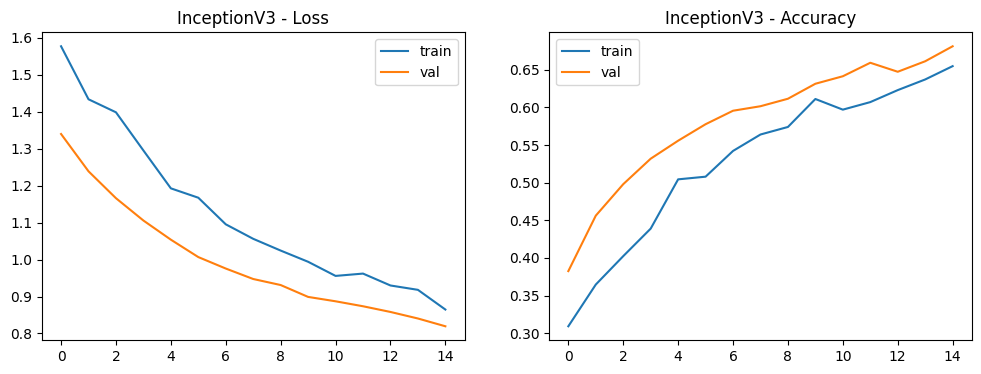

In [10]:
# 5️) MODEL TRAINING

print("✅ Training models...")
results = []

def train_model(model, name):
    print(f"\nTraining {name} ...")
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/{name}_best.h5", save_best_only=True)
    ]
    model.compile(optimizer=optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cb)
    # Plot history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{name} - Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{name} - Accuracy'); plt.legend()
    plt.show()
    return model, history

# Train Custom CNN
custom_cnn, history_cnn = train_model(custom_cnn, "CustomCNN")

# Train Transfer Models
for name, model in transfer_models.items():
    model, hist = train_model(model, name)
    transfer_models[name] = model

✅ Evaluating models...


c:\Users\balaj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\balaj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\balaj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


📊 CustomCNN Results:
Accuracy=0.2195  Precision=0.0482  Recall=0.2195  F1=0.0790
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.22      1.00      0.36        54

    accuracy                           0.22       246
   macro avg       0.05      0.25      0.09       246
weighted avg       0.05      0.22      0.08       246



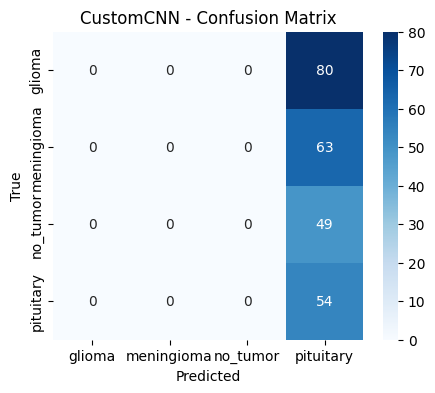

c:\Users\balaj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\balaj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\balaj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


📊 ResNet50 Results:
Accuracy=0.3943  Precision=0.2639  Recall=0.3943  F1=0.2658
              precision    recall  f1-score   support

      glioma       0.36      1.00      0.53        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.74      0.35      0.47        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.39       246
   macro avg       0.27      0.34      0.25       246
weighted avg       0.26      0.39      0.27       246



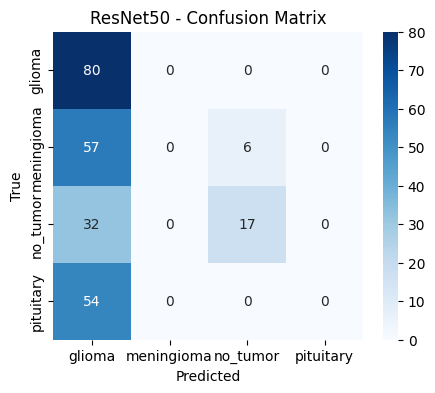


📊 MobileNetV2 Results:
Accuracy=0.6260  Precision=0.6430  Recall=0.6260  F1=0.6239
              precision    recall  f1-score   support

      glioma       0.70      0.61      0.65        80
  meningioma       0.51      0.48      0.49        63
    no_tumor       0.81      0.59      0.68        49
   pituitary       0.57      0.85      0.68        54

    accuracy                           0.63       246
   macro avg       0.65      0.63      0.63       246
weighted avg       0.64      0.63      0.62       246



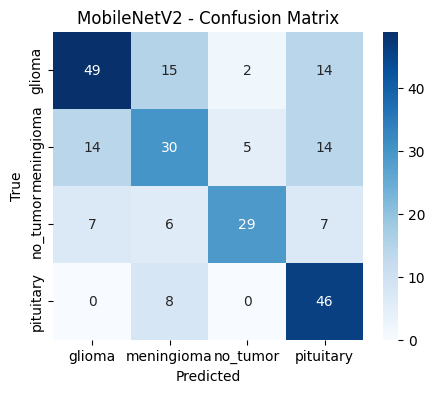


📊 InceptionV3 Results:
Accuracy=0.6748  Precision=0.6882  Recall=0.6748  F1=0.6613
              precision    recall  f1-score   support

      glioma       0.74      0.76      0.75        80
  meningioma       0.58      0.35      0.44        63
    no_tumor       0.86      0.65      0.74        49
   pituitary       0.57      0.94      0.71        54

    accuracy                           0.67       246
   macro avg       0.69      0.68      0.66       246
weighted avg       0.69      0.67      0.66       246



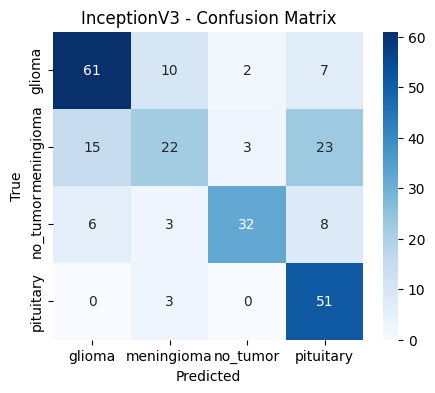

In [11]:
# 6️) MODEL EVALUATION

print("✅ Evaluating models...")

def evaluate_model(model, name):
    y_true, y_pred = [], []
    for imgs, labels in test_ds:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"\n📊 {name} Results:")
    print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# Evaluate all models
results.append(evaluate_model(custom_cnn, "CustomCNN"))
for name, model in transfer_models.items():
    results.append(evaluate_model(model, name))


✅ Model Comparison Summary:
         model  accuracy  precision    recall        f1
3  InceptionV3  0.674797   0.688244  0.674797  0.661281
2  MobileNetV2  0.626016   0.642979  0.626016  0.623925
1     ResNet50  0.394309   0.263890  0.394309  0.265785
0    CustomCNN  0.219512   0.048186  0.219512  0.079024


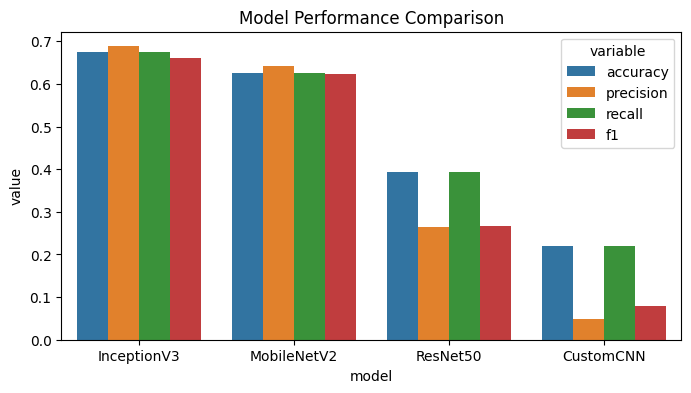


🏆 Best Performing Model: InceptionV3


In [12]:
# 7️) MODEL COMPARISON

df = pd.DataFrame(results).sort_values("f1", ascending=False)
print("\n✅ Model Comparison Summary:")
print(df)

plt.figure(figsize=(8,4))
sns.barplot(data=df.melt(id_vars='model', value_vars=['accuracy','precision','recall','f1']),
            x='model', y='value', hue='variable')
plt.title("Model Performance Comparison")
plt.show()

best_model_name = df.iloc[0]["model"]
print(f"\n🏆 Best Performing Model: {best_model_name}")

In [13]:
import pickle
from tensorflow.keras.models import load_model

# save to h5
best_model_path = f"models_outputs/{best_model_name}_best.h5"
best_model = load_model(best_model_path)

# Save to pickle
pickle_path = f"models_outputs/{best_model_name}_best.pkl"
with open(pickle_path, "wb") as f:
    pickle.dump(best_model, f)

print(f"✅ Saved best model as: {pickle_path}")

✅ Saved best model as: models_outputs/InceptionV3_best.pkl
